In [1]:
# Cell A: imports & device
import os, json, random, time, math, shutil
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # synchronous CUDA errors for clear stack traces

from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image

from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.anchor_utils import AnchorGenerator

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch: 2.5.1+cu121
cuda available: True


In [2]:
# Cell B: paths & basic config (adapt if you want the 512px resized set)
from pathlib import Path
DATA_DIR       = Path("data")
IMAGES_DIR     = DATA_DIR / "PadChest_GR"                      # or DATA_DIR / "PadChest_GR_resized_512_512"
ANNOT_JSON_SRC = DATA_DIR / "grounded_reports_20240819 (1).json"

COCO_DIR       = DATA_DIR / "coco_padchest"
COCO_DIR.mkdir(exist_ok=True, parents=True)

TRAIN_SPLIT    = 0.9   # 90/10 split
SEED           = 42
random.seed(SEED)

print("Images dir exists:", IMAGES_DIR.exists())
print("Labels file exists:", ANNOT_JSON_SRC.exists())


Images dir exists: True
Labels file exists: True


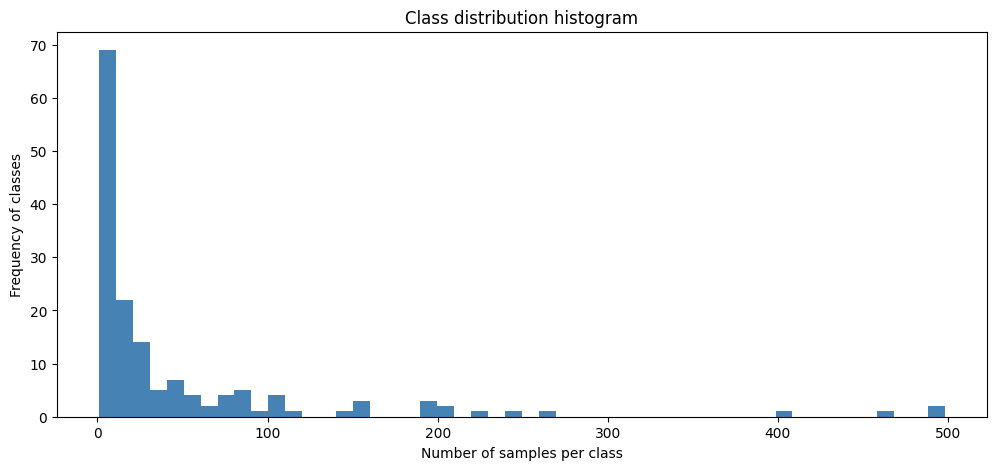

cardiomegaly                             498
chronic changes                          493
aortic elongation                        464
scoliosis                                408
vertebral degenerative changes           269
aortic atheromatosis                     243
air trapping                             225
pleural effusion                         208
apical pleural thickening                205
interstitial pattern                     195
vascular hilar enlargement               193
costophrenic angle blunting              191
infiltrates                              154
laminar atelectasis                      154
fibrotic band                            153
alveolar pattern                         146
increased density                        112
callus rib fracture                      108
pacemaker                                104
kyphosis                                 103
pseudonodule                             103
calcified granuloma                      100
nodule    

,class,count
0,cardiomegaly,498
1,chronic changes,493
2,aortic elongation,464
3,scoliosis,408
4,vertebral degenerative changes,269
5,aortic atheromatosis,243
6,air trapping,225
7,pleural effusion,208
8,apical pleural thickening,205
9,interstitial pattern,195


In [6]:
# Cell C2: Class distribution (histogram + full list)

import json, collections
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# path to JSON
ANNOT_JSON_SRC = Path("data/grounded_reports_20240819 (1).json")

# load JSON
with open(ANNOT_JSON_SRC, "r", encoding="utf-8") as f:
    items = json.load(f)

# count labels
label_counts = collections.Counter()
for it in items:
    for fnd in it.get("findings", []):
        labels = fnd.get("labels") or []
        for l in labels:
            if isinstance(l, str) and l.strip():
                label_counts[l.strip()] += 1

# convert to DataFrame
df_classes = pd.DataFrame(label_counts.items(), columns=["class", "count"])
df_classes = df_classes.sort_values("count", ascending=False).reset_index(drop=True)

# histogram
plt.figure(figsize=(12,5))
plt.hist(df_classes["count"], bins=50, color="steelblue")
plt.xlabel("Number of samples per class")
plt.ylabel("Frequency of classes")
plt.title("Class distribution histogram")
plt.show()

# print each class and its count
for _, row in df_classes.iterrows():
    print(f"{row['class']:<40} {row['count']}")

# also display as a DataFrame (easier to sort/filter in notebook)
df_classes.head(20)  # top 20


In [7]:
# Cell C3: Filter classes (keep only those with >=100 samples) and rebuild COCO

import json
from pathlib import Path
from PIL import Image

ANNOT_JSON_SRC = Path("data/grounded_reports_20240819 (1).json")
IMAGES_DIR     = Path("data/PadChest_GR")    # adjust if using resized set
COCO_DIR       = Path("data/coco_padchest_filtered")
COCO_DIR.mkdir(exist_ok=True, parents=True)

# --- Step 1: count class frequencies
with open(ANNOT_JSON_SRC, "r", encoding="utf-8") as f:
    items = json.load(f)

from collections import Counter
label_counts = Counter()
for it in items:
    for fnd in it.get("findings", []):
        for l in (fnd.get("labels") or []):
            if isinstance(l, str) and l.strip():
                label_counts[l.strip()] += 1

# --- Step 2: choose classes to keep (>=100)
KEEP_THRESHOLD = 100
keep_classes = {label for label, c in label_counts.items() if c >= KEEP_THRESHOLD}
print(f"Keeping {len(keep_classes)} classes out of {len(label_counts)}")

# --- Step 3: rebuild COCO JSON
def to_coco_split_filtered(items, images_dir, keep_classes, train_ratio=0.9):
    # filter findings to only keep chosen labels
    filtered_items = []
    for it in items:
        findings = []
        for fnd in it.get("findings", []):
            labels = [l for l in (fnd.get("labels") or []) if l in keep_classes]
            if labels and fnd.get("boxes"):
                fnd_copy = dict(fnd)
                fnd_copy["labels"] = labels
                findings.append(fnd_copy)
        if findings:
            it_copy = dict(it)
            it_copy["findings"] = findings
            filtered_items.append(it_copy)

    # build category dict
    cat_list = sorted(keep_classes)
    cat_to_id = {name: i+1 for i, name in enumerate(cat_list)}
    categories = [{"id": cid, "name": name, "supercategory": "finding"} for name, cid in cat_to_id.items()]

    # split train/val
    import random
    ids = list(range(len(filtered_items)))
    random.shuffle(ids)
    split_idx = int(len(ids) * train_ratio)
    split = {"train": ids[:split_idx], "val": ids[split_idx:]}

    outputs = {}
    ann_id = 1
    for split_name, idxs in split.items():
        images, annotations = [], []
        for i in idxs:
            it = filtered_items[i]
            fn = it["ImageID"]
            img_path = images_dir / fn
            if not img_path.exists():
                continue
            with Image.open(img_path) as im:
                W, H = im.size

            img_id = i + 1
            images.append({"id": img_id, "file_name": fn, "width": W, "height": H})

            for fnd in it["findings"]:
                lbl = fnd["labels"][0]  # take first label
                cat_id = cat_to_id[lbl]
                for b in fnd["boxes"]:
                    x1, y1, x2, y2 = b
                    x1p, y1p = x1*W, y1*H
                    x2p, y2p = x2*W, y2*H
                    w, h = x2p - x1p, y2p - y1p
                    if w <= 1 or h <= 1: continue
                    annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": cat_id,
                        "bbox": [float(x1p), float(y1p), float(w), float(h)],
                        "area": float(w*h),
                        "iscrowd": 0
                    })
                    ann_id += 1

        outputs[split_name] = {
            "images": images,
            "annotations": annotations,
            "categories": categories,
            "info": {"version": "1.0", "description": "PadChest-GR COCO filtered (>=100 samples)"},
            "licenses": [],
        }
    return outputs

coco_filtered = to_coco_split_filtered(items, IMAGES_DIR, keep_classes, train_ratio=0.9)

with open(COCO_DIR / "train.json", "w", encoding="utf-8") as f: 
    json.dump(coco_filtered["train"], f)
with open(COCO_DIR / "val.json", "w", encoding="utf-8") as f: 
    json.dump(coco_filtered["val"], f)

print("Filtered COCO train imgs:", len(coco_filtered["train"]["images"]), "anns:", len(coco_filtered["train"]["annotations"]))
print("Filtered COCO val   imgs:", len(coco_filtered["val"]["images"]),   "anns:", len(coco_filtered["val"]["annotations"]))
print("Classes kept:", len(coco_filtered["train"]["categories"]))
print([c["name"] for c in coco_filtered["train"]["categories"]])


Keeping 22 classes out of 154
Filtered COCO train imgs: 2196 anns: 4643
Filtered COCO val   imgs: 244 anns: 489
Classes kept: 22
['air trapping', 'alveolar pattern', 'aortic atheromatosis', 'aortic elongation', 'apical pleural thickening', 'calcified granuloma', 'callus rib fracture', 'cardiomegaly', 'chronic changes', 'costophrenic angle blunting', 'fibrotic band', 'increased density', 'infiltrates', 'interstitial pattern', 'kyphosis', 'laminar atelectasis', 'pacemaker', 'pleural effusion', 'pseudonodule', 'scoliosis', 'vascular hilar enlargement', 'vertebral degenerative changes']


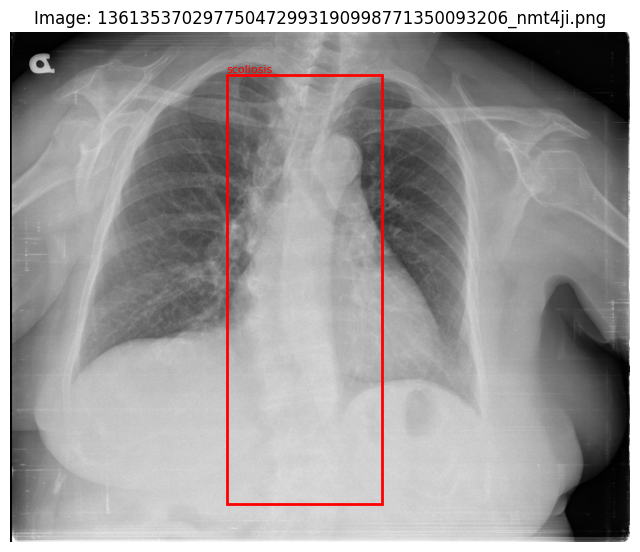

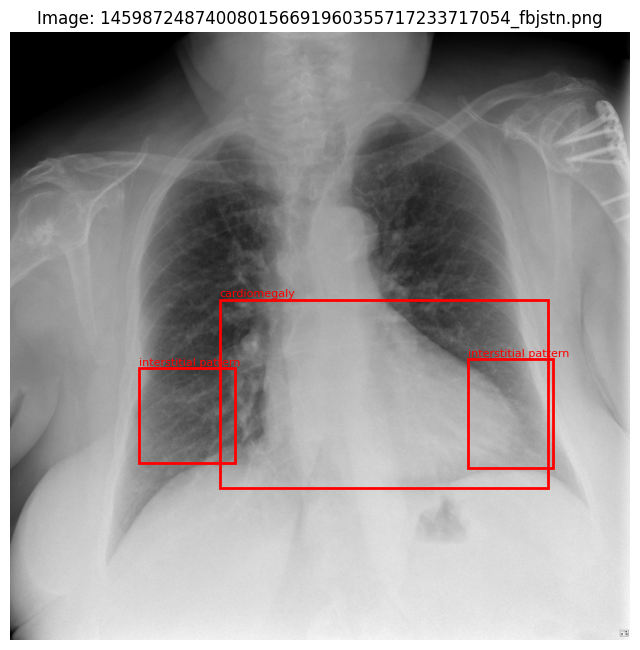

In [13]:
# Cell C4 (simple): Plot raw image with bounding boxes using matplotlib only
import random, json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

COCO_DIR   = Path("data/coco_padchest_filtered")
IMAGES_DIR = Path("data/PadChest_GR")

# load COCO JSON
with open(COCO_DIR / "train.json", "r", encoding="utf-8") as f:
    coco_data = json.load(f)

images      = coco_data["images"]
annotations = coco_data["annotations"]
categories  = {c["id"]: c["name"] for c in coco_data["categories"]}

# map image_id -> anns
imgid_to_anns = defaultdict(list)
for ann in annotations:
    imgid_to_anns[ann["image_id"]].append(ann)

# pick 2 random images
for img_meta in random.sample(images, 2):
    img_path = IMAGES_DIR / img_meta["file_name"]
    if not img_path.exists():
        continue

    img = Image.open(img_path)
    anns = imgid_to_anns[img_meta["id"]]

    # plot raw image
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap="gray")
    ax = plt.gca()

    # add boxes
    for ann in anns:
        x,y,w,h = ann["bbox"]
        rect = plt.Rectangle((x,y), w, h, fill=False, color="red", linewidth=2)
        ax.add_patch(rect)
        cat_name = categories[ann["category_id"]]
        ax.text(x, y-2, cat_name, color="red", fontsize=8, va="bottom")

    plt.axis("off")
    plt.title(f"Image: {img_meta['file_name']}")
    plt.show()


In [2]:
import json, torch
from pathlib import Path
from collections import defaultdict
from torchvision.ops import box_convert
import torchvision.transforms.functional as TF
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random

IMAGES_DIR = Path("data/PadChest_GR")
COCO_DIR   = Path("data/coco_padchest_filtered")

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class CocoLikeDetection(Dataset):
    def __init__(self, images_root: Path, ann_json: Path, transform_mode='train', target_size=800):
        self.images_root = images_root
        self.transform_mode = transform_mode
        self.target_size = target_size
        
        coco = json.loads(ann_json.read_text(encoding="utf-8"))
        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco["categories"]
        
        self.imgid_to_anns = defaultdict(list)
        for a in self.annotations:
            self.imgid_to_anns[a["image_id"]].append(a)
        
        self.id_to_img = {im["id"]: im for im in self.images}
        self.num_classes = len(self.categories)
        self.catid_to_name = {c["id"]: c["name"] for c in self.categories}

        # Create mapping from COCO IDs (1-22) to model IDs (0-21)
        unique_cat_ids = sorted([c["id"] for c in self.categories])
        self.cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(unique_cat_ids)}
        print(f"Category mapping: {self.cat_id_to_idx}")

    def __len__(self): 
        return len(self.images)

    def resize_image_and_boxes(self, img, boxes):
        """Resize image while maintaining aspect ratio and adjust boxes"""
        orig_w, orig_h = img.size
        
        # Calculate scale to fit within target_size
        scale = self.target_size / max(orig_w, orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        
        # Resize image
        img = TF.resize(img, [new_h, new_w])
        
        # Scale boxes
        if len(boxes) > 0:
            boxes = boxes * scale
        
        return img, boxes, scale

    def __getitem__(self, idx):
        im = self.images[idx]
        img_path = self.images_root / im["file_name"]
        img = Image.open(img_path).convert("RGB")
        
        # Get original image size before any resizing
        orig_w, orig_h = img.size
        
        # Quick thumbnail for faster loading
        img.thumbnail((1024, 1024), Image.LANCZOS)
        thumb_w, thumb_h = img.size
        
        # Calculate thumbnail scale
        thumb_scale = min(thumb_w / orig_w, thumb_h / orig_h)
        
        anns = self.imgid_to_anns[im["id"]]

        if len(anns) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            crowd = torch.zeros((0,), dtype=torch.int64)
        else:
            xywh = torch.tensor([a["bbox"] for a in anns], dtype=torch.float32)
            boxes = box_convert(xywh, in_fmt="xywh", out_fmt="xyxy")
            
            # Apply thumbnail scaling to boxes
            boxes = boxes * thumb_scale
            
            # Map category IDs with validation
            labels = []
            valid_boxes = []
            valid_areas = []
            valid_crowds = []
            
            for i, a in enumerate(anns):
                cat_id = a["category_id"]
                if cat_id not in self.cat_id_to_idx:
                    print(f"WARNING: Unknown category_id {cat_id}, skipping")
                    continue
                labels.append(self.cat_id_to_idx[cat_id])
                valid_boxes.append(boxes[i])
                valid_areas.append(a["area"])
                valid_crowds.append(a.get("iscrowd", 0))
            
            boxes = torch.stack(valid_boxes) if valid_boxes else torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            area = torch.tensor(valid_areas, dtype=torch.float32)
            crowd = torch.tensor(valid_crowds, dtype=torch.int64)

        # Resize image and boxes
        img, boxes, resize_scale = self.resize_image_and_boxes(img, boxes)
        img_w, img_h = img.size

        # Apply augmentations
        if self.transform_mode == 'train' and len(boxes) > 0:
            # Random horizontal flip
            if random.random() > 0.5:
                img = TF.hflip(img)
                boxes[:, [0, 2]] = img_w - boxes[:, [2, 0]]
            
            # Color jitter
            img = TF.adjust_brightness(img, random.uniform(0.8, 1.2))
            img = TF.adjust_contrast(img, random.uniform(0.8, 1.2))

        # Clip boxes to image boundaries and remove invalid boxes
        if len(boxes) > 0:
            boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(min=0, max=img_w)
            boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(min=0, max=img_h)
            
            # Calculate box dimensions
            widths = boxes[:, 2] - boxes[:, 0]
            heights = boxes[:, 3] - boxes[:, 1]
            
            # Keep only valid boxes (width > 1 and height > 1)
            valid_mask = (widths > 1) & (heights > 1)
            boxes = boxes[valid_mask]
            labels = labels[valid_mask]
            area = area[valid_mask] if len(area) > 0 else area
            crowd = crowd[valid_mask] if len(crowd) > 0 else crowd

        # Convert to tensor and normalize
        img = TF.to_tensor(img)
        img = TF.normalize(img, IMAGENET_MEAN, IMAGENET_STD)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([im["id"]]),
            "area": area,
            "iscrowd": crowd
        }
        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

# Create datasets
train_set = CocoLikeDetection(IMAGES_DIR, COCO_DIR/"train.json", 
                               transform_mode='train', target_size=800)
val_set = CocoLikeDetection(IMAGES_DIR, COCO_DIR/"val.json", 
                             transform_mode='val', target_size=800)

print(f"Train samples: {len(train_set)}")
print(f"Val samples: {len(val_set)}")
print(f"Number of classes: {train_set.num_classes}")

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, 
                          num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, 
                        num_workers=2, collate_fn=collate_fn)

Category mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21}
Category mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21}
Train samples: 2196
Val samples: 244
Number of classes: 22


In [3]:
# Cell E: DataLoaders
BATCH_SIZE, NUM_WORKERS = 4, 2
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
len(train_loader), len(val_loader)


(549, 61)

In [4]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models import ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = train_set.num_classes  # should be 22 from your filtered COCO
model = retinanet_resnet50_fpn_v2(
    weights=None,                                   # don't load full 91-class head
    weights_backbone=ResNet50_Weights.IMAGENET1K_V2,
    num_classes=NUM_CLASSES,
    trainable_backbone_layers=5
).to(device)

params    = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
lr_sched  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [5]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, epoch, device):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}", leave=True)
    running = {}
    for i, (images, targets) in enumerate(pbar, start=1):
        # Move + enforce dtypes the model expects
        images  = [img.to(device) for img in images]
        targets = [{
            "boxes":   t["boxes"].to(device=device, dtype=torch.float32),
            "labels":  t["labels"].to(device=device, dtype=torch.int64),
            "image_id": t["image_id"].to(device),
            "area":     t["area"].to(device=device, dtype=torch.float32),
            "iscrowd":  t["iscrowd"].to(device=device, dtype=torch.int64),
        } for t in targets]

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            loss_dict = model(images, targets)      # returns dict of losses
            loss = sum(loss_dict.values())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        for k, v in loss_dict.items():
            running[k] = running.get(k, 0.0) + float(v.detach().cpu())
        avg = {k: running[k]/i for k in running}
        pbar.set_postfix({k: f"{v:.4f}" for k, v in avg.items()})


C:\Users\pc\AppData\Local\Temp\ipykernel_3576\3128852869.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    train_one_epoch(model, train_loader, optimizer, epoch, device)
    lr_sched.step()


Epoch 1:   0%|          | 0/549 [00:00<?, ?it/s]C:\Users\pc\AppData\Local\Temp\ipykernel_3576\3128852869.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1:  19%|█▉        | 103/549 [10:32<50:20,  6.77s/it, classification=1.0479, bbox_regression=0.4728] 

In [9]:
from torch.utils.data import DataLoader
import torch, traceback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # no grads needed to trigger the same target checks
dbg_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

bad_idx = None
with torch.no_grad():
    for i, (images, targets) in enumerate(dbg_loader):
        try:
            # move + enforce dtypes
            images  = [img.to(device) for img in images]
            targets = [{
                "boxes":   t["boxes"].to(device=device, dtype=torch.float32),
                "labels":  t["labels"].to(device=device, dtype=torch.int64),
                "image_id": t["image_id"].to(device),
                "area":     t["area"].to(device=device, dtype=torch.float32),
                "iscrowd":  t["iscrowd"].to(device=device, dtype=torch.int64),
            } for t in targets]

            _ = model(images, targets)  # forward only (no loss needed to trip the assert)
        except Exception as e:
            print(f"\n⚠️  Failure at dataset index {i}")
            print("Image ID:", targets[0]["image_id"].item())
            print("Labels min/max:", int(targets[0]["labels"].min()), int(targets[0]["labels"].max()))
            print("Boxes:", targets[0]["boxes"].cpu().numpy())
            traceback.print_exc()
            bad_idx = i
            break

print("Done. Bad index:", bad_idx)



⚠️  Failure at dataset index 0
Image ID: 100
Labels min/max: 8 20
Boxes: [[ 858.6276   563.2125  1576.8818  1974.408  ]
 [1162.5505  1057.4152  1757.8933  1887.5408 ]
 [ 942.45874  429.4202  1327.7604  1994.1569 ]]
Done. Bad index: 0


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_18332\4173197385.py", line 13, in <module>
    images  = [img.to(device) for img in images]
               ^^^^^^^^^^^^^^
RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [10]:
# Batch scanner: find the first bad batch and print details
import os, torch, traceback
from math import isfinite

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # DEBUG ONLY; remove after you fix the data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train()
bad_batch = None

for bi, (images, targets) in enumerate(train_loader):
    try:
        # move + strong dtype guards
        images  = [img.to(device) for img in images]
        targets = [{
            "boxes":   t["boxes"].to(device=device, dtype=torch.float32),
            "labels":  t["labels"].to(device=device, dtype=torch.int64),
            "image_id": t["image_id"].to(device),
            "area":     t["area"].to(device=device, dtype=torch.float32),
            "iscrowd":  t["iscrowd"].to(device=device, dtype=torch.int64),
        } for t in targets]

        # forward once – if something is wrong in this batch, it will assert here
        _ = model(images, targets)
    except Exception as e:
        print(f"\n⚠️  FAILURE at batch index {bi} (batch_size={len(images)})")
        # print per-sample info to spot the culprit
        for si, t in enumerate(targets):
            labels = t["labels"].detach().cpu()
            boxes  = t["boxes"].detach().cpu()
            print(f"  sample {si}: image_id={int(t['image_id'])} labels[min,max]=({int(labels.min()) if labels.numel() else None}, {int(labels.max()) if labels.numel() else None})")
            # flag any non-finite or non-positive-area boxes
            if boxes.numel():
                x1,y1,x2,y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
                w = x2 - x1; h = y2 - y1
                bad_nonfinite = ~torch.isfinite(boxes).all()
                bad_area = ((w <= 0) | (h <= 0)).any()
                print(f"    boxes count={len(boxes)} nonfinite={bool(bad_nonfinite)} nonpos_area={bool(bad_area)}")
                # optionally print a few boxes
                print("    first 3 boxes:", boxes[:3].numpy())
        traceback.print_exc()
        bad_batch = bi
        break

print("Done. bad_batch:", bad_batch)



⚠️  FAILURE at batch index 0 (batch_size=4)
  sample 0: image_id=424 labels[min,max]=(20, 20)
    boxes count=1 nonfinite=False nonpos_area=False
    first 3 boxes: [[ 787.6474  667.4528 1316.0475 1927.2701]]
  sample 1: image_id=705 labels[min,max]=(14, 22)
    boxes count=3 nonfinite=False nonpos_area=False
    first 3 boxes: [[ 208.59375 1014.0625  1003.90625 1850.     ]
 [1832.0312  1017.96875 2771.0938  2079.6875 ]
 [1162.5      620.3125  1471.0938  1962.5    ]]
  sample 2: image_id=534 labels[min,max]=(22, 22)
    boxes count=1 nonfinite=False nonpos_area=False
    first 3 boxes: [[-262.82263  538.6185   146.47247 1218.4366 ]]
  sample 3: image_id=793 labels[min,max]=(1, 1)
    boxes count=4 nonfinite=False nonpos_area=False
    first 3 boxes: [[  81.161316 1171.7523    486.47354  1234.5248  ]
 [-476.38086  1230.7203    -82.48584  1344.852   ]
 [ 151.56769   481.2554    475.0563    888.32513 ]]
Done. bad_batch: 0


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_18332\1810124733.py", line 14, in <module>
    images  = [img.to(device) for img in images]
               ^^^^^^^^^^^^^^
RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [8]:
import torch, math

def check_one_batch(model, loader, device, num_classes):
    model.train()
    images, targets = next(iter(loader))
    # move & types
    images  = [img.to(device) for img in images]
    clean_targets = []
    for t in targets:
        t = {k: v.clone() for k,v in t.items()}  # avoid in-place surprises
        t["labels"] = t["labels"].to(torch.int64).to(device)
        t["boxes"]  = t["boxes"].to(torch.float32).to(device)
        clean_targets.append(t)

    # print quick stats
    all_labels = torch.cat([t["labels"].cpu() for t in clean_targets], dim=0)
    print("labels: min=", int(all_labels.min()) if all_labels.numel() else None,
          "max=", int(all_labels.max()) if all_labels.numel() else None,
          "num_classes(model)=", model.head.classification_head.num_classes if hasattr(model, "head") else "unknown")

    # hard assertions (fail fast)
    for bi, t in enumerate(clean_targets):
        if t["labels"].numel():
            assert (t["labels"] >= 1).all() and (t["labels"] <= num_classes).all(), f"Label OOB in sample {bi}"
        if t["boxes"].numel():
            x1y1x2y2 = t["boxes"]
            w = x1y1x2y2[:,2] - x1y1x2y2[:,0]
            h = x1y1x2y2[:,3] - x1y1x2y2[:,1]
            assert torch.isfinite(x1y1x2y2).all(), f"Non-finite box in sample {bi}"
            assert (w > 0).all() and (h > 0).all(), f"Non-positive area box in sample {bi}"

    # forward once to surface device-side assert here (easier to debug)
    loss_dict = model(images, clean_targets)
    loss = sum(loss_dict.values())
    loss.backward()
    print("Single-batch forward/backward OK.")
    return True

_ = check_one_batch(model, train_loader, device, train_set.num_classes)


labels: min= 8 max= 21 num_classes(model)= 22
Single-batch forward/backward OK.
